# **데이터 전처리**

## **데이터 소환**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# pandas, numpy, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# get df
df = pd.read_csv("/content/drive/MyDrive/DAT/data/diabetes_prediction_dataset.csv")

## **01.데이터 전처리**

In [20]:
# 결측치 처리
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [21]:
# 중복 행 확인
df.duplicated().sum()
df.shape

(100000, 9)

In [22]:
# 나이 변수 형변환
df['age'] = df['age'].astype(int)

In [23]:
# Others 행 없애기
df = df[df['gender'] != 'Other']

In [24]:
# dummy
gender_dummies = pd.get_dummies(df['gender'])
df = pd.concat([df, gender_dummies], axis = 1)
df=df.drop(['gender'],axis = 1)

In [25]:
df["smoking_history"].value_counts()

No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: smoking_history, dtype: int64

In [26]:
# smoking_history 열 전체 제거
df.drop(["smoking_history"], axis = 1, inplace = True)

In [27]:
# 맨 오른쪽 열으로 이동
cols = df.columns.tolist()
cols.remove('diabetes')
df = df[cols+['diabetes']]

## **02.Train/Test 나누기 + 정규화**

In [28]:
# set X, y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [29]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# **Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [32]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('랜덤포레스트 정확도: {:.4f}'.format(accuracy))

랜덤포레스트 정확도: 0.9691


In [33]:
# RFC.score() : RandomForestClassifier 클래스 안에 있는 분류 결과의 정확도(Accuracy)를 계산하는 함수다. 입력 데이터는 Test Data의 feature와 target 값이다.
# 위의 코드랑 사실상 같은 코드임
rf_clf.score(X_test, y_test)

0.9691453718057709

In [34]:
# classification_report 함수 : precision 값과 recall 값, f1-score 값을 출력해줌.
# ㄴ(A,B)와 (B,A) 서로 값이 다르게 나오는 이유 확인 필요!

from sklearn.metrics import classification_report 
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18712
           1       0.70      0.92      0.79      1285

    accuracy                           0.97     19997
   macro avg       0.85      0.95      0.89     19997
weighted avg       0.98      0.97      0.97     19997



In [35]:
# Grid Search (실행 시 시간 오래 걸리니 주의 바람)
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[10,100], 'max_depth':[6,12,18]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3)     # CV : CV(Cross Validation) 검증을 위한 분할 검증 횟수 지정
grid_cv.fit(X_train, y_train)

print('일반모델 최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

일반모델 최적 하이퍼파라미터:  {'max_depth': 12, 'n_estimators': 100}
최고 예측 정확도: 0.9720


In [36]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

feature_importance = pd.DataFrame(rf_clf.feature_importances_.reshape((1, -1)), columns=X_train.columns, index=['feature_importance'])
feature_importance

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,Female,Male
feature_importance,0.103507,0.016611,0.010459,0.142322,0.411565,0.312673,0.001428,0.001435


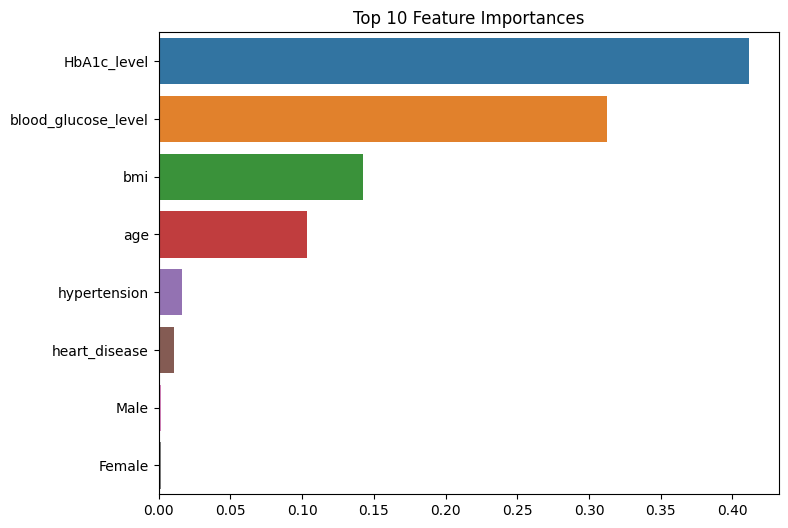

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [39]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

max_dia = df[df['diabetes'] == 1]
min_dia = df[df['diabetes'] == 0]
undersample = RandomUnderSampler(random_state = 42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
y_train_under.value_counts()

0    6792
1    6792
Name: diabetes, dtype: int64

In [40]:
# Undersampled X, y를 활용한 랜덤포레스트 구성
rf_clf_under = RandomForestClassifier(random_state = 42)
rf_clf_under.fit(X_train_under, y_train_under)
y_pred = rf_clf_under.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('언더샘플링 랜덤포레스트 정확도: {:.4f}'.format(accuracy))

언더샘플링 랜덤포레스트 정확도: 0.8972


In [41]:
# Grid Search

from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [10,100],'max_depth' : [6,12]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf_under = RandomForestClassifier(random_state = 0)
grid_cv = GridSearchCV(rf_clf_under, param_grid = params, cv = 3)
grid_cv.fit(X_train_under, y_train_under)

print('언더모델 최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

언더모델 최적 하이퍼파라미터:  {'max_depth': 12, 'n_estimators': 100}
최고 예측 정확도: 0.9097


In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_clf_under = RandomForestClassifier()
rf_clf_under.fit(X_train_under, y_train_under)

RandomForestClassifier()

In [43]:
feature_importance_under = pd.DataFrame(rf_clf_under.feature_importances_.reshape((1, -1)), columns=X_train_under.columns, index=['feature_importance_under'])
feature_importance_under

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,Female,Male
feature_importance_under,0.196688,0.025345,0.016288,0.137764,0.341772,0.277452,0.002315,0.002375


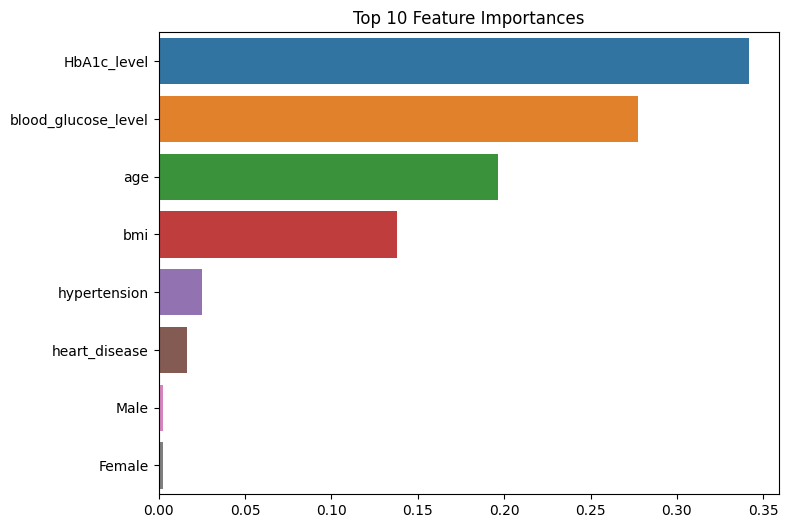

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf_under.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train_under.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()